In [72]:
help(sunode.wrappers.as_theano.solve_ivp)

Help on function solve_ivp in module sunode.wrappers.as_theano:

solve_ivp(t0: float, y0: numpy.ndarray, params: Dict[str, Any], tvals: numpy.ndarray, rhs: Callable[[sympy.core.symbol.Symbol, numpy.ndarray, numpy.ndarray], Dict[str, Any]], derivatives: str = 'adjoint', coords: Optional[Dict[str, pandas.core.indexes.base.Index]] = None, make_solver=None, derivative_subset=None, solver_kwargs=None, simplify=None) -> Any



In [23]:
with pm.Model() as model:
    x = pm.Data('x', [1., 2., 3.])

In [27]:
x.eval()

array([1., 2., 3.])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
from pymc3.ode import DifferentialEquation
import theano.tensor as tt
import theano
import datetime
import shelve
from datetime import datetime as dt
import time

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# Versions

In [2]:
pm.__version__

'3.11.4'

In [3]:
theano.__version__

'1.1.2'

In [4]:
az.__version__

'0.11.2'

In [5]:
np.__version__

'1.21.6'

In [6]:
sunode.__version__

'0.2'

# Setup

In [7]:
np.random.seed(0)

In [8]:
class COVID_data():
 
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)
 
 

In [9]:
class SIR_model():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0)
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', prior['lam'], prior['lambda_std'])
            mu = pm.Lognormal('mu', prior['mu'], prior['mu_std'])
 
            res = self.sir_model_non_normalized(y0=[self.S0, self.I0], theta=[lam, mu])
 
            if(likelihood['distribution'] == 'lognormal'):
                Y = pm.Lognormal('Y', mu=pm.math.log(res.take(0, axis=1)), sigma=sigma, observed=self.covid_data.cases_obs[1:])
            else:
                Y = pm.StudentT( "Y",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res.take(0, axis=1),     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=cases_obs[1:]
                        )
            trace = pm.sample(self.n_samples, tune=self.n_tune, target_accept=0.9, cores=1)
            data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()

In [165]:
# Much faster than above, uses sunode library
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.predict_time_range = np.arange(
            len(self.covid_data.cases_obs),
            len(self.covid_data.cases_obs) + self.covid_data.num_days_to_predict,
            1
        )
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam_mu = np.log(self.prior['lam']) + self.prior['lambda_std']**2
            mu_mu = np.log(self.prior['mu']) + self.prior['mu_std']**2
            lam = pm.Lognormal('lambda', lam_mu , self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', mu_mu, self.prior['mu_std'])           # 1.5, 1.5
 
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
            y0={
            # The initial conditions of the ode. Each variable
            # needs to specify a theano or numpy variable and a shape.
            # This dict can be nested.
                'S': (self.S_init, ()),
                'I': (self.I_init, ()),
            },
            params={
            # Each parameter of the ode. sunode will only compute derivatives
            # with respect to theano variables. The shape needs to be specified
            # as well. It it infered automatically for numpy variables.
            # This dict can be nested.
                'lam': (lam, ()),
                'mu': (mu, ()),
                '_dummy': (np.array(1.), ())
            },
            # A functions that computes the right-hand-side of the ode using
            # sympy variables.
            rhs=self.SIR_sunode,
            # The time points where we want to access the solution
            tvals=self.time_range,
            # Time corresponding to initial values
            t0=self.time_range[0]
            )
    
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
 
            theano.printing.Print('S')(res['S'])
            print('Problem',problem)
            print('Solver',solver)
 
            R = 1 - (res['I'] + res['S'])
            #S = 1 - (res['I'][1:])
            #theano.printing.Print('R')(R)
            R0 = pm.Deterministic('R0',lam/mu)
 
            step = pm.Metropolis()
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=1)
            data = az.from_pymc3(trace=trace)
            
            # Posterior predictive
            ppc = pm.sample_posterior_predictive(trace)
        
        # Plot the posterior predicted samples, i.e. these are samples of predicted y for each original x in our data
        az.plot_hdi(self.time_range, ppc['I'], hdi_prob=0.89, color='lightblue')
        # Plot the true y values
        plt.plot(self.time_range, self.covid_data.cases_obs, 'b.')
        plt.title("Posterior Predictive")
        plt.xlabel("Day")
        plt.ylabel("Number of Cases")
        
        # Plots
        t1 = time.time() - t
        az.plot_posterior(data, round_to=2, point_estimate='mode', hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        # Rug plot of R0
        fig = ff.create_distplot([trace['R0']], group_labels=['R0'])
        fig.update_layout(title_text='Curve and Rug Plot')
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)

# Model Japan

In [166]:
covid_obj = COVID_data('Japan', Population=125.8e6)

In [167]:
covid_obj.get_dates(data_begin='7/11/20', data_end='8/11/20')

------------ Cases for selected period -----------  [21420 21827 22086 22419 22869 23493 24090 24751 25262 25680 26312 27107
 28088 28867 29668 30507 31107 32092 33362 34670 36256 37790 39121 40086
 41332 42687 44172 45777 47348 48789 49627 50324]
------------- Cases yesterday (2020-08-11): 50324 and day before yesterday: 49627 ------------
------------ Day before start and cases for that date ------------ 2020-08-10 00:00:00 [49627]
------------- Future date begin and end ------------- 8/12/20 8/26/20
------------- Future days cases ------------ [51303 52475 53831 55062 56079 56726 57642 58712 59890 60927 61911 62655
 63148 63863 64766]


# Lognormal Likelihood

In [168]:
# Likelihood function to use
likelihood = {
    'distribution': 'lognormal', 
    'sigma': 2  # width of half-Cauchy prior on lognormal parameter σ
}
# λ is transmission probability times average number of contacts per person per day
# μ is the  recovery rate (the inverse of average infectious period)
prior= {
    'lam': 1.6, 
    'lambda_std': 1.0,
    'mu': 0.4,  
    'mu_std': 0.5
}

Rationale for λ:

- assume the average Japanese person encounters 50 people per day, and transmission probability is 0.1
- λ is somewhere around 5
- Let's set the location parameter of the lognormal distribution to log(5) = 1.61
- The scale parameter is the number of orders of magnitude we think λ could vary over

Rational for μ:
- We think the average infectious period is 7 to 30 days
- μ is then somewhere between 0.03 and 0.14
- That's quite a tight prior, so let's consider μ between 0 and 1.5
- Set location parameter to log(1.5) = 0.41
- Could vary by half an order of magnitude (remember we're dealing with rates here...)

In [169]:
sir_model = SIR_model_sunode(covid_obj)

S __str__ = [9.99829730e-01 9.91160868e-01 7.12303942e-01 7.56881778e-02
 7.75345221e-03 1.84249427e-03 7.73194366e-04 4.58995872e-04
 3.35748581e-04 2.78382646e-04 2.48825484e-04 2.32646201e-04
 2.23464003e-04 2.18139098e-04 2.15010958e-04 2.13159059e-04
 2.12057626e-04 2.11400722e-04 2.11008289e-04 2.10773617e-04
 2.10633202e-04 2.10549155e-04 2.10498837e-04 2.10468708e-04
 2.10450666e-04 2.10439863e-04 2.10433392e-04 2.10429518e-04
 2.10427197e-04 2.10425808e-04 2.10424976e-04 2.10424477e-04]
Problem <sunode.symode.problem.SympyProblem object at 0x19537d490>
Solver <sunode.solver.AdjointSolver object at 0x1963bf880>


/var/folders/v_/s2wx6q8d189d5hs7nf38yz8r0000gn/T/ipykernel_25204/2997794600.py:101: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu, lambda, sigma]



[CVODES ERROR]  CVode
  At t = 0.0951519, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00149746, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0111259, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00479056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0104672, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000892914, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVOD


[CVODES ERROR]  CVode
  At t = 0.0281108, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.016491, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000625981, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000625981, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00583572, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00583572, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVO


[CVODES ERROR]  CVode
  At t = 0.00522802, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00522802, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00177749, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000465961, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0




[CVODES ERROR]  CVode
  At t = 0.00803016, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00101366, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00461614, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00296535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00220309, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000296458, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[C


[CVODES ERROR]  CVode
  At t = 0.00642777, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00064376, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00403714, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00229714, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00064376, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00177915, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV

/Users/jennifer/miniforge3_x86_64/envs/pymc3/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning:

hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions

/Users/jennifer/miniforge3_x86_64/envs/pymc3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



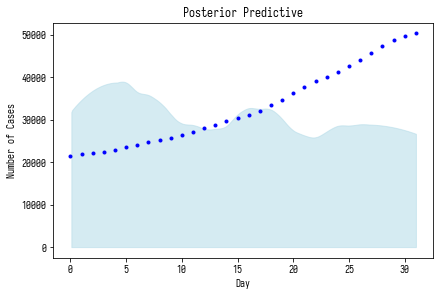

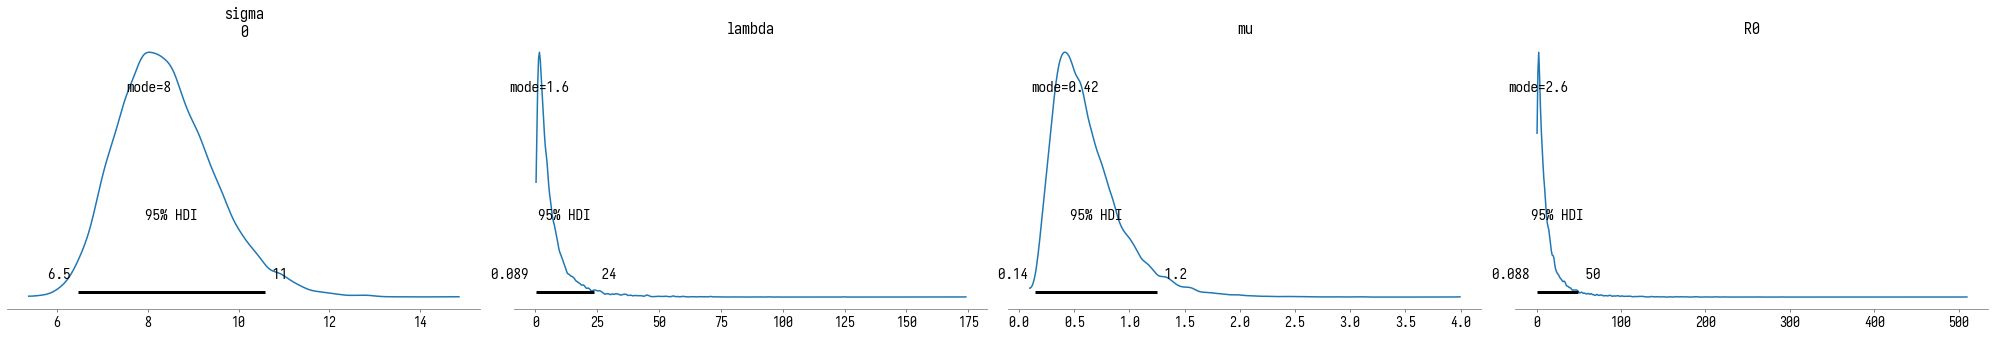

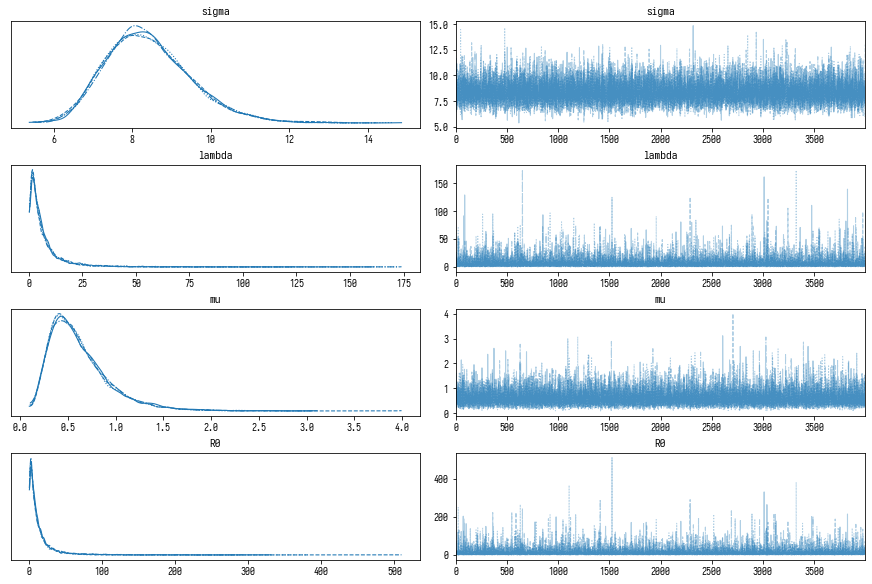

In [170]:
sir_model.run_SIR_model(n_samples=4000, n_tune=1000, likelihood=likelihood, prior=prior)

# Student Likelihood

In [ ]:
# Likelihood function to use
likelihood = {
    'distribution': 'student', 
    'sigma':, 2  # width of half-Cauchy prior on lognormal parameter σ
    'nu': 60  # want the student distribution to be close to normal
}
# λ is transmission probability times average number of contacts per person per day
# μ is the  recovery rate (the inverse of average infectious period)
prior= {
    'lam': 1.6, 
    'lambda_std': 1.0,
    'mu': 0.4,  
    'mu_std': 0.5
}

# Using pymc3 ode (slow)

In [ ]:
sir_model = SIR_model(covid_obj)

In [ ]:
sir_model.run_SIR_model(n_samples=20, n_tune=10, likelihood=likelihood, prior=prior)